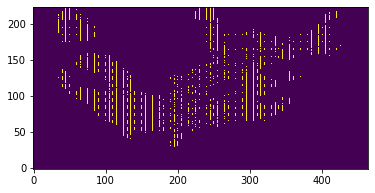

00810grids. Zero-value points = 3309. Sample percent = 0.0


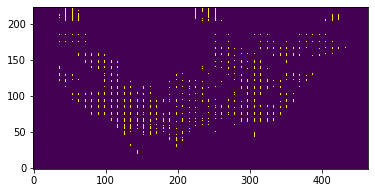

00974grids. Zero-value points = 1140. Sample percent = 0.01


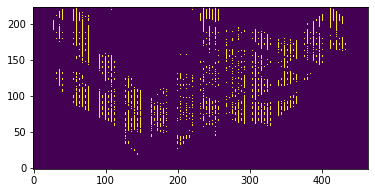

01225grids. Zero-value points = 4314. Sample percent = 0.01


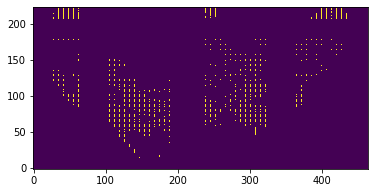

01610grids. Zero-value points = 1617. Sample percent = 0.02


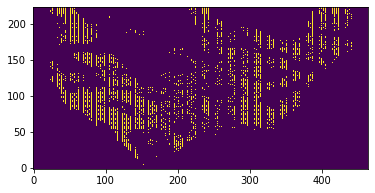

02251grids. Zero-value points = 5743. Sample percent = 0.01


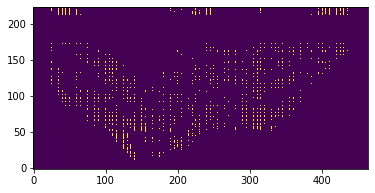

03186grids. Zero-value points = 1809. Sample percent = 0.02


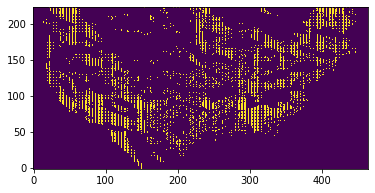

04951grids. Zero-value points = 8782. Sample percent = 0.01


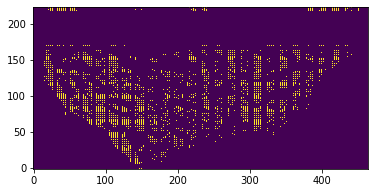

08884grids. Zero-value points = 4196. Sample percent = 0.02


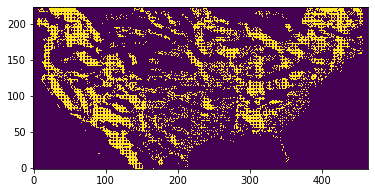

19922grids. Zero-value points = 19259. Sample percent = 0.01
Done


In [12]:
import os
import pandas as pd
import xarray as xr
import datetime
import numpy as np
import matplotlib.pyplot as plt

root_dir = '/glade/u/home/hongli/scratch/2020_04_21nldas_gmet'   
SampleMode = 'uniform'
stnlist_dir = os.path.join(root_dir, 'scripts/step1_sample_stnlist_'+SampleMode)
stnlist_name_base = 'stnlist'

outfolder = 'scripts/step15_check_regr_'+SampleMode
if not os.path.exists(os.path.join(root_dir, outfolder)):
    os.makedirs(os.path.join(root_dir, outfolder))

#----------------------------------------------------------
# read gmet output grids
grid_info_file = os.path.join(root_dir,'data/nldas_topo/conus_ens_grid_eighth.nc')
f = xr.open_dataset(os.path.join(root_dir,grid_info_file))
mask_grid_info = f['mask'].values[:] # 1 is valid. 0 is invalid. 
latitude = f['latitude'].values[:] 
longitude = f['longitude'].values[:] 
elev = f['elev'].values[:] 
gradient_n_s = f['gradient_n_s'].values[:] 
gradient_w_e = f['gradient_w_e'].values[:] 

#----------------------------------------------------------
# loop stnlists
stnlist_files = [f for f in os.listdir(stnlist_dir) if stnlist_name_base in f]
stnlist_files = sorted(stnlist_files)

for stnlist_file in stnlist_files:
        
    CaseID = (stnlist_file.split('.')[0].split('_')[1])
    regr_dir = os.path.join(root_dir,'test_'+SampleMode,CaseID)
    regr_file = os.path.join(regr_dir,'gmet_regr/regress_ts.weight.nc')
    
    # read regression nc
    f=xr.open_dataset(regr_file)
    tmean = f.variables['tmean'][:][0,:,:]
    tmean_2 = f.variables['tmean_2'][:][0,:,:]
    mask_tmean_2 = (tmean_2==0)

    # mask zero-value grids
    plt.imshow(((mask_tmean_2==True) & (mask_grid_info==True)),origin='lower')
    plt.show()

    [y_ids,x_ids]=np.where((mask_tmean_2==True) & (mask_grid_info==True))
    ids = np.transpose([y_ids,x_ids]) #(row_id, col_id)
    isssue_grids_num = len(ids)

    # test if zero-value points are stn
    stnlist_dir = os.path.join(root_dir, 'scripts/step1_sample_stnlist_'+SampleMode)
    stn_ids = np.loadtxt(os.path.join(stnlist_dir,stnlist_file), skiprows=2, usecols=[0], delimiter=',', dtype='str') # STA_ID[0], LAT[1], LON[2] ELEV[3], SLP_N[4], SLP_E[5], STA_NAME[6]
    stnlist = np.loadtxt(os.path.join(stnlist_dir,stnlist_file), skiprows=2, usecols=[1,2,3,4,5], delimiter=',') 

    stn_lat_id = [int(stn_ids[i][3:3+3]) for i in range(len(stn_ids))] #start from zero
    stn_lon_id = [int(stn_ids[i][9:9+3]) for i in range(len(stn_ids))] 
    stn_ids = np.transpose([stn_lat_id,stn_lon_id])

    record = []
    count = 0
    for i in range(isssue_grids_num):
        for j in range(len(stn_ids)):
            if ((ids[i,0] == stn_ids[j,0]) & (ids[i,1] == stn_ids[j,1])):
                judge = 1
                count = count+1
            else:
                judge = 0

        row = ids[i,0]
        col = ids[i,1]
        record.append([row, col, judge,
                       latitude[row,col],
                       longitude[row,col],
                       elev[row,col],
                       gradient_n_s[row,col],
                       gradient_w_e[row,col]])
    perct = round(count/float(isssue_grids_num),2)
    print(CaseID+'. Zero-value points = '+str(isssue_grids_num)+'. Sample percent = '+str(perct))

    ofile = os.path.join(root_dir, outfolder, CaseID+'_zero-value_'+str(perct)+'.txt')
    np.savetxt(ofile, record, fmt='%d,%d,%d,%.4f,%.4f,%.2f,%.2f,%.2f', 
               header='y_id,x_id,Sample(Yes=1,No=0),Lat,Lon,Elev,gradient_n_s,gradient_w_e')


print('Done')

In [4]:
stn_ids

array([[  0, 110],
       [  0, 140],
       [  0, 150],
       ...,
       [220, 440],
       [220, 450],
       [220, 460]])

In [7]:
ids[i,:], (ids[i,0] in stn_ids[:,0]) & (ids[i,1] in stn_ids[:,1])

(array([223, 250]), False)

In [10]:
[j for j in range(len(stn_ids)) if ((ids[i,0] == stn_ids[j,0]) & (ids[i,1] == stn_ids[j,1]))]

[]

In [6]:
tmean_crr_mb1[0,200:203,100:103],tmean_crr_mb2[0,200:203,100:103],tmean_crr_mean[0,200:203,100:103]

(<xarray.Variable (lat: 3, lon: 3)>
 array([[-2.260754, -2.317753, -2.445198],
        [-2.055662, -2.211776, -2.361637],
        [-2.013566, -2.193542, -2.357734]], dtype=float32)
 Attributes:
     long_name:  estimated daily mean temperature
     units:      deg_C, <xarray.Variable (lat: 3, lon: 3)>
 array([[-2.037866, -2.116956, -2.256951],
        [-1.862239, -2.032399, -2.078563],
        [-1.757651, -1.904244, -1.980003]], dtype=float32)
 Attributes:
     long_name:  estimated daily mean temperature
     units:      deg_C, <xarray.Variable (lat: 3, lon: 3)>
 array([[-2.14931 , -2.217355, -2.351074],
        [-1.95895 , -2.122088, -2.2201  ],
        [-1.885608, -2.048893, -2.168869]], dtype=float32)
 Attributes:
     long_name:  estimated daily mean temperature
     units:      deg_C)

In [7]:
(-2.260754-2.037866)/2

-2.14931